In [1]:
from joblib import Parallel, delayed
from __init__ import *
import Setting as _C
reload(_C)
import utils as _U
reload(_U)

<module 'utils' from 'c:\\Users\\shuai.song\\data\\Causis\\CTA_Trend\\utils.py'>

In [3]:
trading_logs = {}
all_buy = pd.DataFrame()
all_sell = pd.DataFrame()
all_total = pd.DataFrame()

for com in _C.commodities.keys():
    com_log = np.load(f'output/trading_logs/{com}_logs.npy', allow_pickle=True)
    com_log = com_log.tolist() # [BUY_log, SELL_log, TOTAL_log]
    trading_logs[com] = com_log

In [16]:
def Judge_Pos(com):
    ddf = pd.read_csv(f'output/features/{com}_features.csv')
    ddf = ddf.set_index('CLOCK.1')

    ddf['signal'] = np.zeros(ddf.shape[0])
    clock_list = ddf['CLOCK'].to_list()

    for i in range(trading_logs[com][0].shape[0]):
        entry = trading_logs[com][0].iloc[i]
        start = entry['open_bar']
        end = entry['close_bar']
        ddf['signal'].loc[start: end] = 1

    for i in range(trading_logs[com][1].shape[0]):
        entry = trading_logs[com][1].iloc[i]
        start = entry['open_bar']
        end = entry['close_bar']
        ddf['signal'].loc[start: end] = -1

    return ddf

In [17]:
F_data=  {}
tasks = []
## Positions
for com in _C.commodities.keys():
    tasks.append(delayed(Judge_Pos)(com))

multi_work = Parallel(n_jobs=8, backend='threading', verbose=80)
res = multi_work(tasks)

for com in _C.commodities.keys():
    F_data[com] = res[list(_C.commodities.keys()).index(com)]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:   10.0s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   3 out of  15 | elapsed:   10.3s remaining:   41.4s
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:   11.0s remaining:   30.3s
[Parallel(n_jobs=8)]: Done   5 out of  15 | elapsed:   11.2s remaining:   22.5s
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:   11.4s remaining:   17.1s
[Parallel(n_jobs=8)]: Done   7 out of  15 | elapsed:   14.0s remaining:   16.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:   14.7s remaining:   12.9s
[Parallel(n_jobs=8)]: Done   9 out of  15 | elapsed:   16.3s remaining:   10.9s
[Parallel(n_jobs=8)]: Done  10 out of  15 | elapsed:   20.0s remaining:   10.0s
[Parallel(n_jobs=8)]: Done  11 out of  15 | elapsed:   20.1s remaining:    7.2s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   20.6

In [18]:
def plot_all(scom, t_start, t_end):
    stmp = F_data[scom][t_start:t_end].copy(deep=True)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5), dpi=150, sharex=True)
    axes[0].tick_params(labelsize=7)
    axes[1].tick_params(labelsize=7)

    ## Subplot 0
    # K bars
    sdf = pd.DataFrame()
    sdf['CLOCK'] = stmp['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = stmp['OPEN']
    sdf['Close'] = stmp['CLOSE']
    sdf['High'] = stmp['HIGH']
    sdf['Low'] = stmp['LOW']
    sdf['Volume'] = stmp['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)
    mpf.plot(sdf, ax = axes[0], type='candle', style = s, ylabel='')
    
    # Super Trends
    stmp['UB_S'].loc[stmp['STD_S']== 1] = np.nan
    stmp['LB_S'].loc[stmp['STD_S']==-1] = np.nan

    stmp['UB_L'].loc[stmp['STD_L']== 1] = np.nan
    stmp['LB_L'].loc[stmp['STD_L']==-1] = np.nan

    stmp['UB_S'].plot(ax=axes[0], color='g', linestyle='--', alpha=0.8, linewidth=0.6)
    stmp['LB_S'].plot(ax=axes[0], color='r', linestyle='--', alpha=0.8, linewidth=0.6)

    stmp['UB_L'].plot(ax=axes[0], color='blue', linestyle='-.', alpha=0.8, linewidth=1.2)
    stmp['LB_L'].plot(ax=axes[0], color='orange', linestyle='-.', alpha=0.8, linewidth=1.2)
    axes[0].legend()

    ## Subplot 1
    stmp['CLOSE'].plot(ax=axes[1], color='b', alpha=0.8, linewidth=0.8)
    ax_twin = axes[1].twinx()
    ax_twin.tick_params(labelsize=7)
    ax_twin.set_ylim(-1,1)
    axes[1].legend(loc='upper right')

    # BUY_POS = stmp.loc
    BUY_POS = stmp.copy(deep=True)
    BUY_POS['signal'].loc[BUY_POS['signal']!=1]=0
    plt.bar(BUY_POS.index.to_list(), BUY_POS['signal'], color='pink', alpha=0.5, label='BUY Pos')

    SELL_POS = stmp.copy(deep=True)
    SELL_POS['signal'].loc[SELL_POS['signal']!=-1]=0
    plt.bar(SELL_POS.index.to_list(), SELL_POS['signal'], color='green', alpha=0.5, label='SELL Pos')
    ax_twin.legend(loc='upper left')

    x_ticks = []
    for i in range(stmp.shape[0]):
        if i % 10 == 0:
            x_ticks.append(stmp['CLOCK'].iloc[i])
        else:
            x_ticks.append('')
    ax_twin.set_xticklabels(labels=x_ticks,visible=False)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

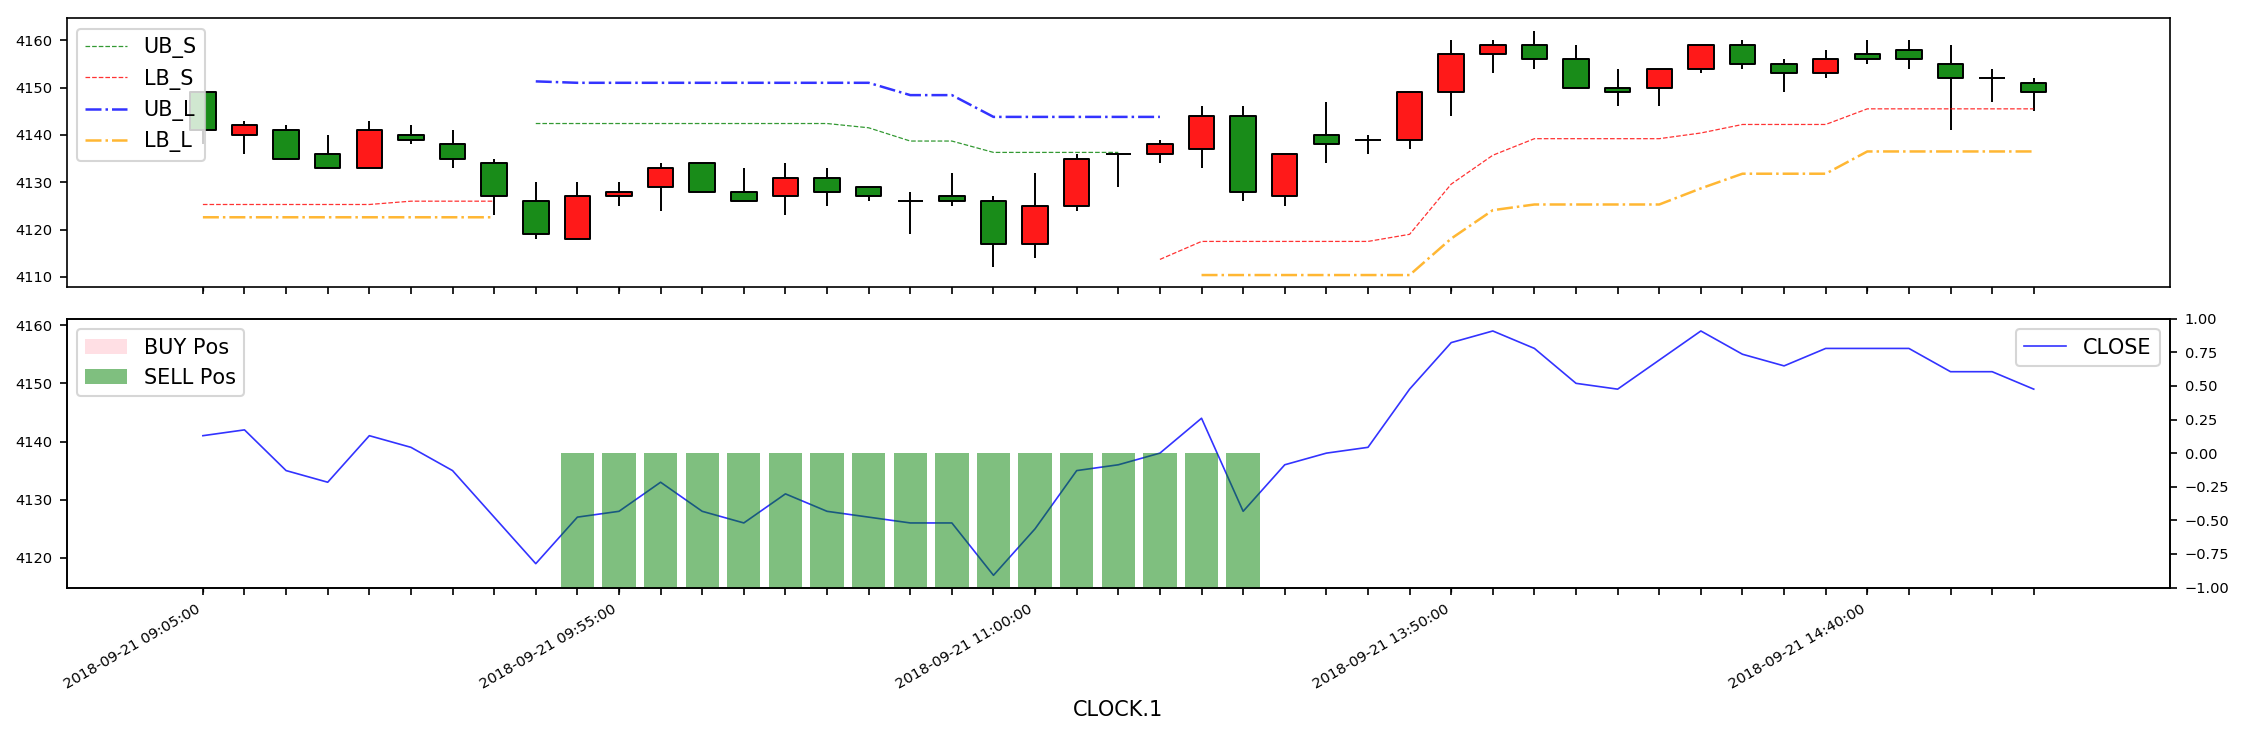

In [26]:
plot_all('rb', '2018-09-21 09:05:00', '2018-09-22 09:05:00')